In [3]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from random import randint
import  random
import os
# os.chdir('C:/Users/Travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from cmath import nan
import urllib
import urllib.request
import re
import time


In [4]:
os.getcwd()

'/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/V2_Newer_Notebooks'

#### Get sitemap for fighters

In [23]:
url = 'https://www.tapology.com/fightcenter/fighters/sitemap.xml'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(url, headers = header)
r.text

# turn into df
df = pd.DataFrame(r.text.split('\n'))
df.columns = ['url']
df = df[df['url'].str.contains('fighter')]
df

,url
3,<loc>https://www.tapology.com/fightcenter/...
9,<loc>https://www.tapology.com/fightcenter/...
15,<loc>https://www.tapology.com/fightcenter/...
21,<loc>https://www.tapology.com/fightcenter/...
27,<loc>https://www.tapology.com/fightcenter/...
...,...
26913,<loc>https://www.tapology.com/fightcenter/...
26919,<loc>https://www.tapology.com/fightcenter/...
26925,<loc>https://www.tapology.com/fightcenter/...
26931,<loc>https://www.tapology.com/fightcenter/...


Get fighter first and last names. 

Some contain middle names, and most also contain nicknames. 
It typically goes: First-Last-The-Nickname

In [24]:
df['whole_name'] = df['url'].str.split('/').str[-2]

# if whole_name has numbers, remove them
df['whole_name'] = df['whole_name'].str.replace(r'\d+', '')
# if first character is a number, remove number
df['whole_name'] = df['whole_name'].str.replace(r'^\d+','')
# if first character is a space, remove space
df['whole_name'] = df['whole_name'].str.replace(r'^\s+','')
df

,url,whole_name
3,<loc>https://www.tapology.com/fightcenter/...,dan-henderson-hollywood<
9,<loc>https://www.tapology.com/fightcenter/...,rich-franklin-ace<
15,<loc>https://www.tapology.com/fightcenter/...,mauricio-rua-shogun<
21,<loc>https://www.tapology.com/fightcenter/...,mark-coleman-the-hammer<
27,<loc>https://www.tapology.com/fightcenter/...,alan-belcher-the-talent<
...,...,...
26913,<loc>https://www.tapology.com/fightcenter/...,-jennifer-howe<
26919,<loc>https://www.tapology.com/fightcenter/...,-anthony-marti<
26925,<loc>https://www.tapology.com/fightcenter/...,-ana-carolina<
26931,<loc>https://www.tapology.com/fightcenter/...,-tommy-hayden<


In [25]:
# if whole_name starts with -, remove only first character
df['whole_name'] = df['whole_name'].apply(lambda x: x[1:] if x.startswith('-') else x)
df

,url,whole_name
3,<loc>https://www.tapology.com/fightcenter/...,dan-henderson-hollywood<
9,<loc>https://www.tapology.com/fightcenter/...,rich-franklin-ace<
15,<loc>https://www.tapology.com/fightcenter/...,mauricio-rua-shogun<
21,<loc>https://www.tapology.com/fightcenter/...,mark-coleman-the-hammer<
27,<loc>https://www.tapology.com/fightcenter/...,alan-belcher-the-talent<
...,...,...
26913,<loc>https://www.tapology.com/fightcenter/...,jennifer-howe<
26919,<loc>https://www.tapology.com/fightcenter/...,anthony-marti<
26925,<loc>https://www.tapology.com/fightcenter/...,ana-carolina<
26931,<loc>https://www.tapology.com/fightcenter/...,tommy-hayden<


In [26]:
# delete all '<'
df['whole_name'] = df['whole_name'].str.replace('<', '')
# replace - with space
df['whole_name'] = df['whole_name'].str.replace('-', ' ')
# add column to count words in whole_name
df['word_count'] = df['whole_name'].str.split().str.len()
df

,url,whole_name,word_count
3,<loc>https://www.tapology.com/fightcenter/...,dan henderson hollywood,3
9,<loc>https://www.tapology.com/fightcenter/...,rich franklin ace,3
15,<loc>https://www.tapology.com/fightcenter/...,mauricio rua shogun,3
21,<loc>https://www.tapology.com/fightcenter/...,mark coleman the hammer,4
27,<loc>https://www.tapology.com/fightcenter/...,alan belcher the talent,4
...,...,...,...
26913,<loc>https://www.tapology.com/fightcenter/...,jennifer howe,2
26919,<loc>https://www.tapology.com/fightcenter/...,anthony marti,2
26925,<loc>https://www.tapology.com/fightcenter/...,ana carolina,2
26931,<loc>https://www.tapology.com/fightcenter/...,tommy hayden,2


In [27]:
def extract_nickname(row):
    # check the word_count column to see if there is a nickname
    if row['word_count'] > 2:
        # fighter name is first two words in whole_name
        row['Fighter Name'] = ' '.join(row['whole_name'].split(' ')[:2])
        # nickname is the last part
        row['Nickname'] = ' '.join(row['whole_name'].split(' ')[-2:])
    else:
        row['Fighter Name'] = row['whole_name']
        row['Nickname'] = np.nan
        
    return row

# Apply the function
df = df.apply(extract_nickname, axis=1)
df.head(50)

,url,whole_name,word_count,Fighter Name,Nickname
3,<loc>https://www.tapology.com/fightcenter/...,dan henderson hollywood,3,dan henderson,henderson hollywood
9,<loc>https://www.tapology.com/fightcenter/...,rich franklin ace,3,rich franklin,franklin ace
15,<loc>https://www.tapology.com/fightcenter/...,mauricio rua shogun,3,mauricio rua,rua shogun
21,<loc>https://www.tapology.com/fightcenter/...,mark coleman the hammer,4,mark coleman,the hammer
27,<loc>https://www.tapology.com/fightcenter/...,alan belcher the talent,4,alan belcher,the talent
33,<loc>https://www.tapology.com/fightcenter/...,denis kang super korean,4,denis kang,super korean
39,<loc>https://www.tapology.com/fightcenter/...,chris lytle lights out,4,chris lytle,lights out
45,<loc>https://www.tapology.com/fightcenter/...,marcus davis the irish hand grenade,6,marcus davis,hand grenade
51,<loc>https://www.tapology.com/fightcenter/...,andrei arlovski the pitbull,4,andrei arlovski,the pitbull
57,<loc>https://www.tapology.com/fightcenter/...,fedor emelianenko the last emperor,5,fedor emelianenko,last emperor


In [28]:
df['sherdog_urls'] = df['url'].str.replace('<loc>', "").str.replace('<url>', '').str.strip()
df

,url,whole_name,word_count,Fighter Name,Nickname,sherdog_urls
3,<loc>https://www.tapology.com/fightcenter/...,dan henderson hollywood,3,dan henderson,henderson hollywood,https://www.tapology.com/fightcenter/fighters/...
9,<loc>https://www.tapology.com/fightcenter/...,rich franklin ace,3,rich franklin,franklin ace,https://www.tapology.com/fightcenter/fighters/...
15,<loc>https://www.tapology.com/fightcenter/...,mauricio rua shogun,3,mauricio rua,rua shogun,https://www.tapology.com/fightcenter/fighters/...
21,<loc>https://www.tapology.com/fightcenter/...,mark coleman the hammer,4,mark coleman,the hammer,https://www.tapology.com/fightcenter/fighters/...
27,<loc>https://www.tapology.com/fightcenter/...,alan belcher the talent,4,alan belcher,the talent,https://www.tapology.com/fightcenter/fighters/...
...,...,...,...,...,...,...
26913,<loc>https://www.tapology.com/fightcenter/...,jennifer howe,2,jennifer howe,NaN,https://www.tapology.com/fightcenter/fighters/...
26919,<loc>https://www.tapology.com/fightcenter/...,anthony marti,2,anthony marti,NaN,https://www.tapology.com/fightcenter/fighters/...
26925,<loc>https://www.tapology.com/fightcenter/...,ana carolina,2,ana carolina,NaN,https://www.tapology.com/fightcenter/fighters/...
26931,<loc>https://www.tapology.com/fightcenter/...,tommy hayden,2,tommy hayden,NaN,https://www.tapology.com/fightcenter/fighters/...


In [29]:
df= df.drop(['url'], axis = 1)
df

,whole_name,word_count,Fighter Name,Nickname,sherdog_urls
3,dan henderson hollywood,3,dan henderson,henderson hollywood,https://www.tapology.com/fightcenter/fighters/...
9,rich franklin ace,3,rich franklin,franklin ace,https://www.tapology.com/fightcenter/fighters/...
15,mauricio rua shogun,3,mauricio rua,rua shogun,https://www.tapology.com/fightcenter/fighters/...
21,mark coleman the hammer,4,mark coleman,the hammer,https://www.tapology.com/fightcenter/fighters/...
27,alan belcher the talent,4,alan belcher,the talent,https://www.tapology.com/fightcenter/fighters/...
...,...,...,...,...,...
26913,jennifer howe,2,jennifer howe,NaN,https://www.tapology.com/fightcenter/fighters/...
26919,anthony marti,2,anthony marti,NaN,https://www.tapology.com/fightcenter/fighters/...
26925,ana carolina,2,ana carolina,NaN,https://www.tapology.com/fightcenter/fighters/...
26931,tommy hayden,2,tommy hayden,NaN,https://www.tapology.com/fightcenter/fighters/...


In [ ]:
os.chdir('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')

In [ ]:
os.getcwd()

In [ ]:
df.to_csv('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/data/final/aggregates/Sherdog_Fighter_URLs.csv', index = False)

## Scrape One

Note: The names are not all correct!!! Volkanski?!?

Note 2: You can only scrape 30 fighters using the header method, should use selenium

In [37]:
test_url = 'https://www.tapology.com/fightcenter/fighters/40148-islam-makhachev'
#chromedriver = '/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/V2_Newer_Notebooks/chromedriver'

### Fighter Details

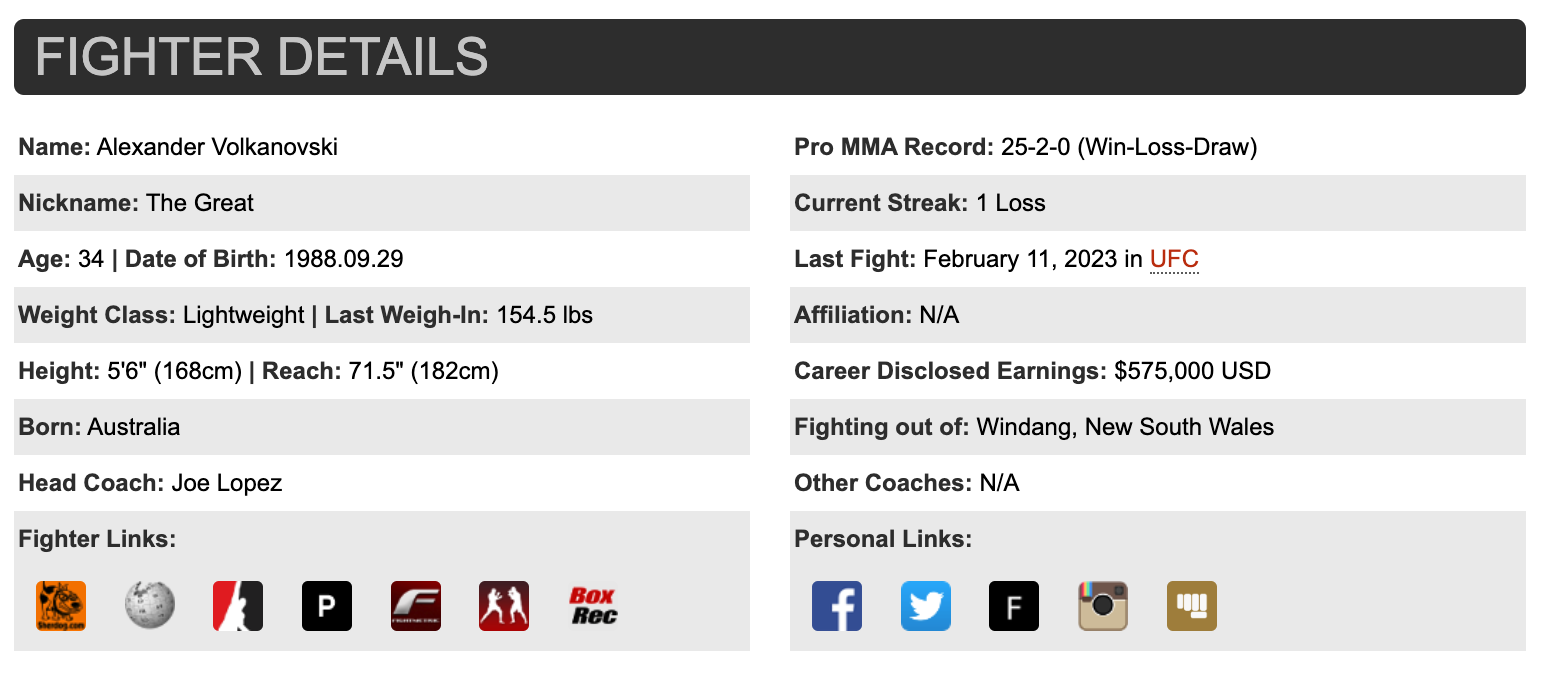

In [6]:
# check working directory
os.getcwd()
# set working directory
os.chdir('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')
os.getcwd()

'/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2'

In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
# chrome_options.add_argument("--headless")
driver = webdriver.Chrome(chromedriver, options=chrome_options)

# set up header for other
headerrr = {
                        "User-Agent": "Mozilla/6.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
                        "X-Requested-With": "XMLHttpRequest"
        }

In [39]:
header2 = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"}

In [8]:
def get_fighter_details(url):
    # scrape with requests, using a header
    header = headerrr

    # scrape with requests
    r = requests.get(url, headers = header)
    soup = BeautifulSoup(r.text, 'html.parser')

    # IF selenium is necessary:
    # driver.get(url)
    # time.sleep(1)
    # soup = BeautifulSoup(driver.page_source, 'html.parser')

    fighter_name = soup.find('div', {'class': 'fighterUpcomingHeader'})

    values = fighter_name.text
    values = values.split('\n')
    # delete empty strings
    values = list(filter(None, values))
    # only keep last item
    values = values[-1]
    fighter_name = values

    # get Fighter Details
    fighter_details = soup.find_all('div', {'class': 'details details_two_columns'})
    fighter_details_text = fighter_details[0].text
    # split on \n
    fighter_details_text = fighter_details_text.split('\n')
    # remove empty strings
    fighter_details_text = list(filter(None, fighter_details_text))
    # replace | with new line
    fighter_details_text = [x.replace('|', '\n') for x in fighter_details_text]
    # replace any '\n ' with ''
    fighter_details_text = [x.replace('\n ', '') for x in fighter_details_text]

    # Creating a dictionary from the list
    fighter_dict = {fighter_details_text[i]: fighter_details_text[i + 1] for i in range(0, len(fighter_details_text), 2)}

    # Converting the dictionary into a DataFrame
    fighter_details = pd.DataFrame(fighter_dict, index=[0])

    # add fighter name
    fighter_details['Fighter Name'] = fighter_name

    # move fighter_name to first column
    cols = fighter_details.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    fighter_details = fighter_details[cols]
    return fighter_details


In [9]:
get_fighter_details(test_url)

,Fighter Name,Given Name:,Pro MMA Record:,Nickname:,Current Streak:,Age:,Date of Birth:,Last Fight:,in,Weight Class:,Last Weigh-In:,Affiliation:,Height:,Reach:,Career Disclosed Earnings:,Born:,Fighting out of:,Fighter Links:
0,Islam Makhachev,Ислам Махачев,24-1-0 (Win-Loss-Draw),N/A,12 Wins,1991-09-27,1991.09.27,"February 11, 2023",UFC,Lightweight,155.0 lbs,Fightspirit Team,"5'10"" (178cm)","70.5"" (179cm)","$202,000 USD","Dagestan, Russia","Makhachkala, Russia",Personal Links:


## Pro MMA Stats

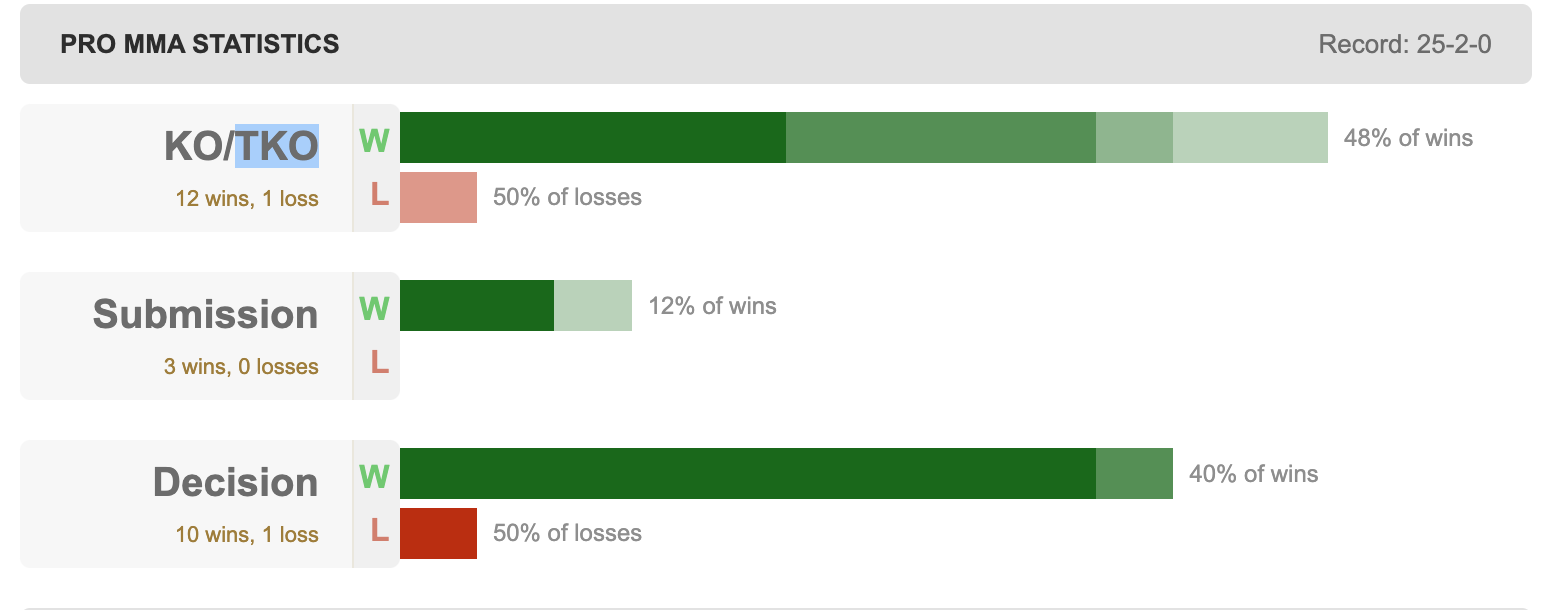

In [12]:
def get_fighter_record_stats(url):
    # scrape with requests, using a header

    # scrape with selenium if necessary
    # driver.get(url)
    # time.sleep(1)
    # soup = BeautifulSoup(driver.page_source, 'html.parser')
    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the fighter record stats
    fighter_record_stats = soup.find_all('ul', {'class': 'fighterRecordStats'})

    # Assuming fighter_record_stats[0] is the BeautifulSoup object containing the ul
    ul = fighter_record_stats[0]

    # Find all li tags - each li corresponds to a different record type
    lis = ul.find_all('li')

    records = []

    # Loop through the li tags
    for li in lis:
        # Get the record type (KO/TKO, Submission, Decision)
        record_type = li.find('div', class_='primary').text
        
        # Get the secondary data - number of wins and losses
        secondary = li.find('div', class_='secondary').text
        wins_losses = secondary.split(',')
        wins = wins_losses[0].strip()
        losses = wins_losses[1].strip() if len(wins_losses) > 1 else '0 losses'
        
        # Get the percentage of wins
        win_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Win'))
        percent_of_win = win_stats.find('div', class_='percentOf') if win_stats else None
        percent_wins = percent_of_win.text.strip() if percent_of_win else 'N/A'
        # replace any \ofwins with ''
        percent_wins = percent_wins.replace('\n', ' ')
        percent_wins = percent_wins.replace('of wins', '')
        
        # Get the percentage of losses
        loss_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Loss'))
        percent_of_loss = loss_stats.find('div', class_='percentOf') if loss_stats else None
        percent_losses = percent_of_loss.text.strip() if percent_of_loss else 'N/A'
        # replace any \oflosses with ''
        percent_losses = percent_losses.replace('\n', ' ')
        percent_losses = percent_losses.replace('of losses', '')
        
        # Add the data to the records list
        records.append([record_type, wins, losses, percent_wins, percent_losses])

    # Convert the list to a DataFrame
    df = pd.DataFrame(records, columns=['Type', 'Wins', 'Losses', 'Percentage of Wins', 'Percentage of Losses'])
    return df

In [14]:
#get_fighter_record_stats(test_url)

## Record by Promotion

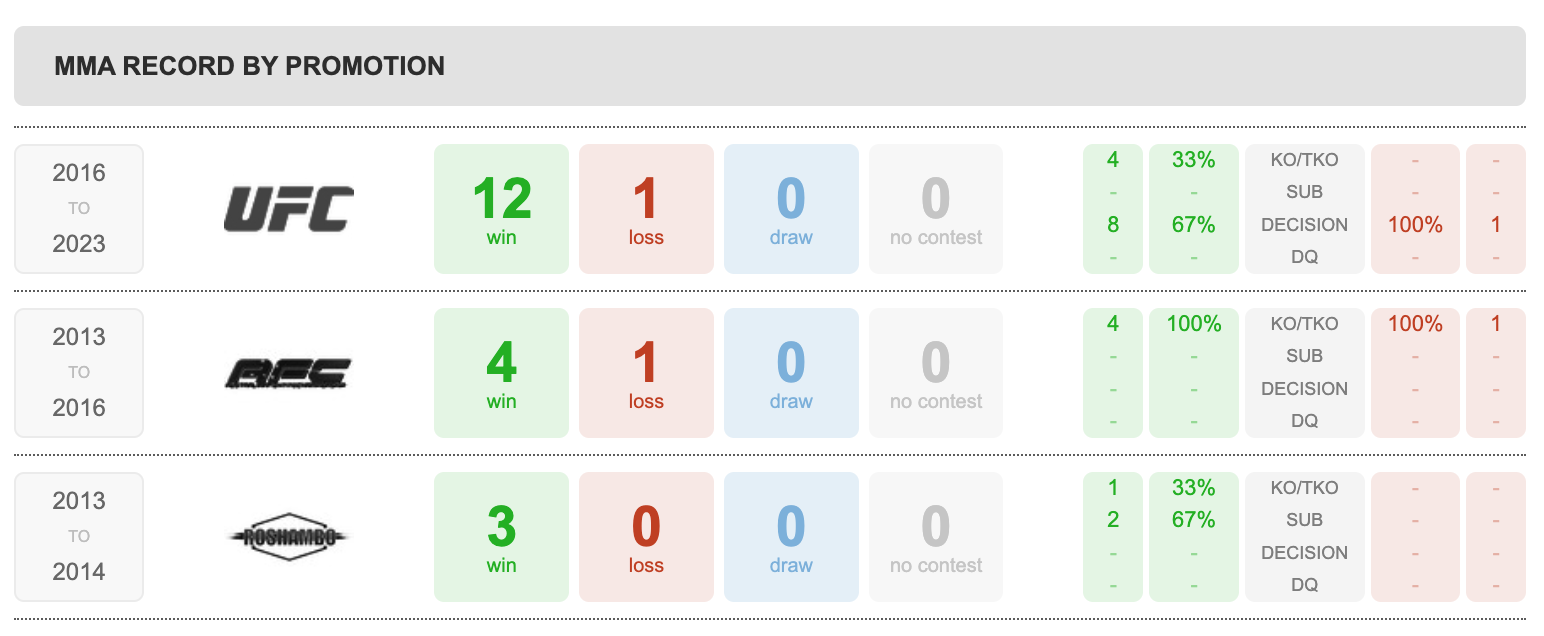

Get Promotions

Get results by promotion

In [15]:
def get_promotion_results(url):
    # # scrape with requests, using a header
    # header = {
    #                     "User-Agent": "Mozilla/6.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
    #                     "X-Requested-With": "XMLHttpRequest"
    #     }

    # # scrape with requests
    # r = requests.get(url, headers = header)
    soup = BeautifulSoup(r.text, 'html.parser')

    # driver.get(url)
    # time.sleep(1)
    # soup = BeautifulSoup(driver.page_source, 'html.parser')
        
    # get mma record by promotion using ul class = 'fighterPromotions'
    fighter_promotions = soup.find_all('ul', {'class': 'fighterPromotions'})

    # Assuming fighter_promotions[0] is the BeautifulSoup object containing the ul
    ul = fighter_promotions[0]

    # Find all li tags - each li corresponds to a different promotion record
    lis = ul.find_all('li')

    promotion_records = []

    # Loop through the li tags
    for li in lis:
        # Get the promotion name
        promotion_name = li.find('img')['title']
        

        # Get the years of participation
        years_active = li.find('div', class_='yearsActive').get_text(separator=' ').strip()
        
        # Get the win-loss record
        wins = li.find('div', class_='wins').get_text(separator=' ').strip()
        losses = li.find('div', class_='losses').get_text(separator=' ').strip()
        draws = li.find('div', class_='draws').get_text(separator=' ').strip()
        no_contests = li.find('div', class_='no_contests').get_text(separator=' ').strip()
        
        # Get the method records
        method_labels = ["KO/TKO", "Sub", "Decision", "DQ"]
        method_wins = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWins')[0].find_all('div', class_='methodRecordRow')]
        method_win_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWinPercent')[0].find_all('div', class_='methodRecordRow')]
        method_losses = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLosses')[0].find_all('div', class_='methodRecordRow')]
        method_loss_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLossPercent')[0].find_all('div', class_='methodRecordRow')]
        
        # Convert method records into a dictionary for easy DataFrame creation
        method_records_dict = {f'{label} Wins': win for label, win in zip(method_labels, method_wins)}
        method_records_dict.update({f'{label} Win Percent': win_percent for label, win_percent in zip(method_labels, method_win_percents)})
        method_records_dict.update({f'{label} Losses': loss for label, loss in zip(method_labels, method_losses)})
        method_records_dict.update({f'{label} Loss Percent': loss_percent for label, loss_percent in zip(method_labels, method_loss_percents)})
        
        # Add the data to the promotion records list
        promotion_records.append([promotion_name, years_active, wins, losses, draws, no_contests, method_records_dict])

    # Convert the list to a DataFrame
    df = pd.DataFrame(promotion_records, columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])

    # Extract method records into separate columns
    df_method_records = pd.DataFrame(df['Method Records'].tolist())
    df = pd.concat([df.drop('Method Records', axis=1), df_method_records], axis=1)
    # drop any \n characters
    df = df.replace('\n','', regex=True)
    # drop any 'win' or 'loss' characters
    df = df.replace('win','', regex=True)
    df = df.replace('loss','', regex=True)
    df = df.replace('draw','', regex=True)
    df = df.replace('no contest','', regex=True)
    # change NA to 0
    df = df.replace('N/A',0, regex=True)

    record_by_promotion = df
    return record_by_promotion

In [17]:
#get_promotion_results('https://www.tapology.com/fightcenter/fighters/40148-islam-makhachev')

## Pro Results Section
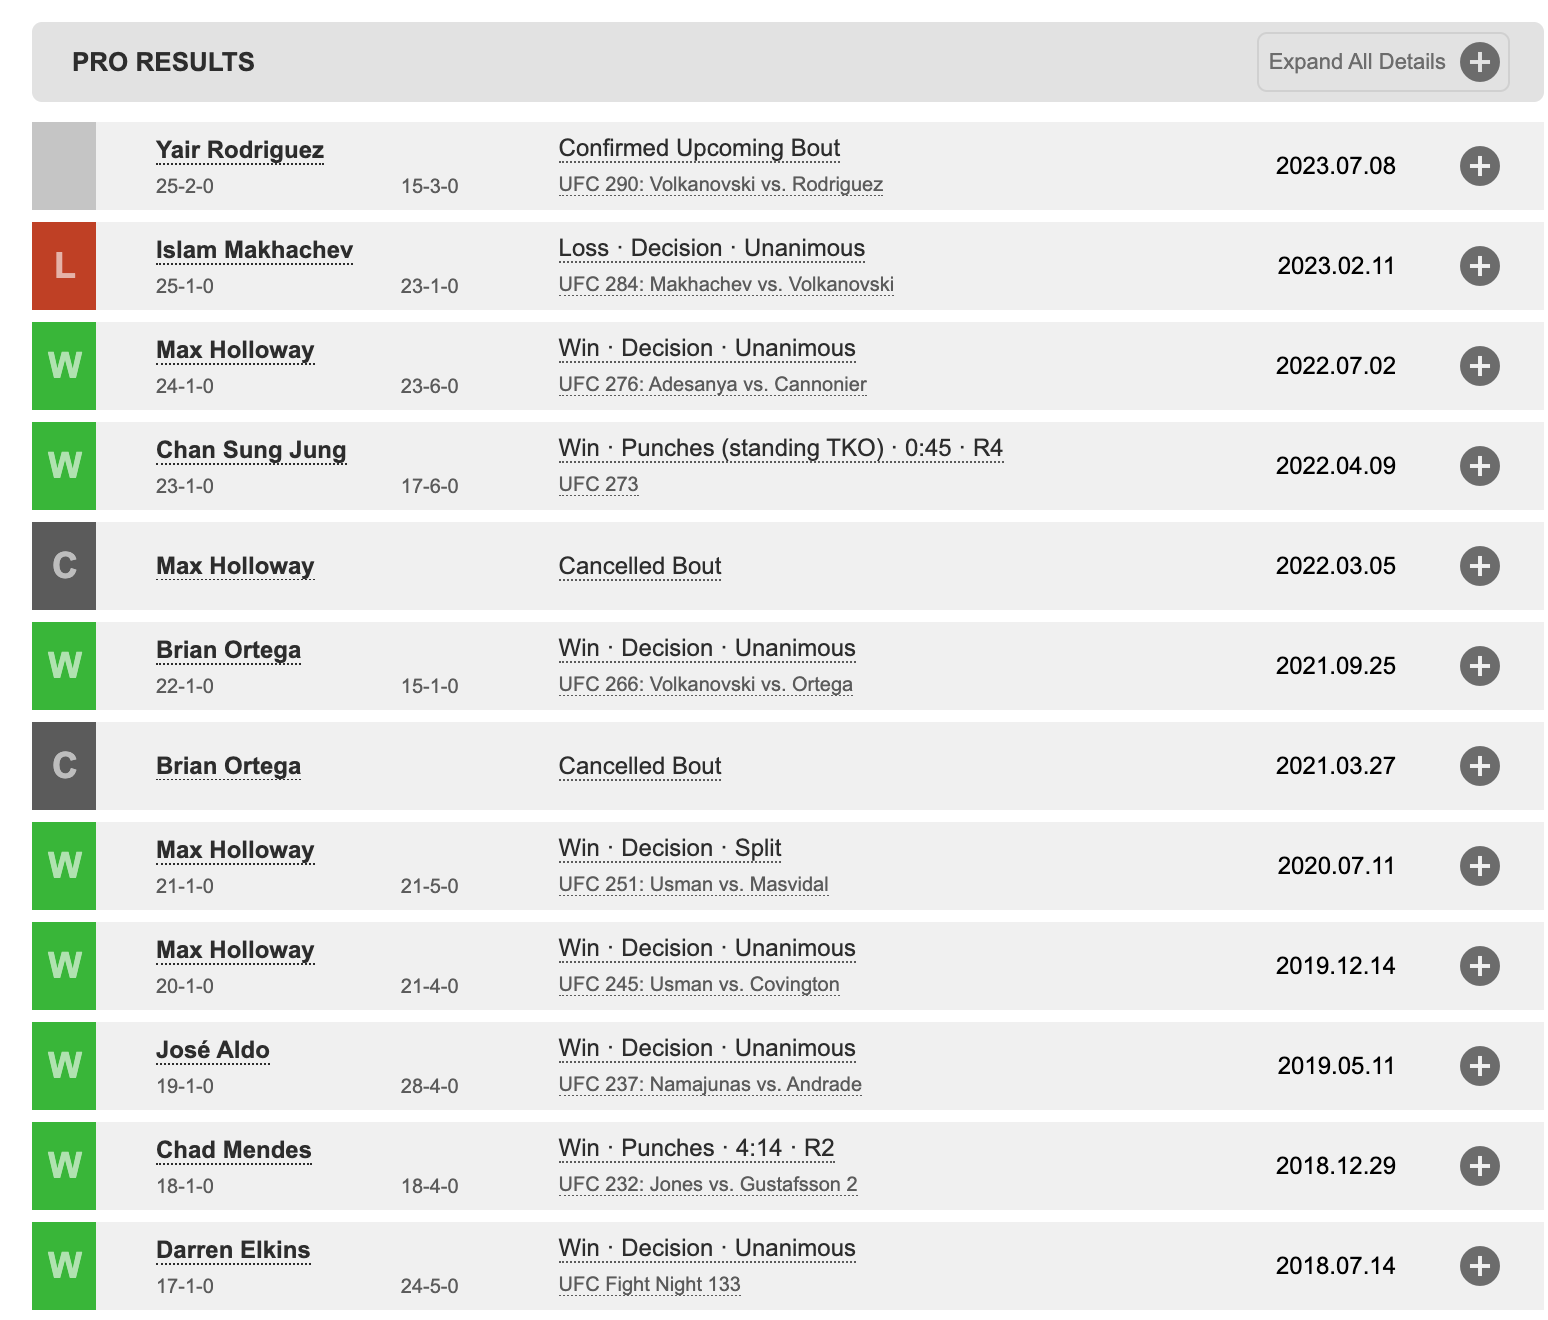

In [18]:

def get_fight_results(url):

    # scrape with requests, using a header
    driver.get(url)
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # scrape fighter fight results (class="fighterFightResults")
    fighter_fight_results = soup.find_all('section', {'class': 'fighterFightResults'})
    # count number of li tags
    len(fighter_fight_results[0].find_all('li'))

    # each li tag is a fight. each fight contains oppenent div, summary div, date div, and more div. 
    # grab all divs within each li tag
    fighter_fight_results_li = fighter_fight_results[0].find_all('li')


    # create an empty list to store the data
    data = []

    # loop through each li tag
    for li in fighter_fight_results_li:
        # create an empty dictionary to store the data for this fight
        fight = {}

        # extract the opponent name using CSS selectors
        name_tag = li.select_one('.opponent .name')
        fight['Opponent Name'] = name_tag.get_text(strip=True) if name_tag else 'N/A'

        # extract the opponent record using CSS selectors
        record_tags = li.select('.opponent .record span')  # this will return a list of span tags
        if record_tags:
            fight['Fighter Record Before Fight'] = record_tags[0].get_text(strip=True) if len(record_tags) > 0 else 'N/A'
            fight['Opponent Record Before Fight'] = record_tags[1].get_text(strip=True) if len(record_tags) > 1 else 'N/A'
        else:
            fight['Fighter Record Before Fight'] = 'N/A'
            fight['Opponent Record Before Fight'] = 'N/A'

        # extract the fight summary and event using CSS selectors
        summary_lead = li.select_one('.summary .lead a')
        if summary_lead is not None:
            fight['Fight Summary'] = summary_lead.get_text(strip=True)
        else:
            fight['Fight Summary'] = 'N/A'

        summary_notes = li.select_one('.summary .notes a')
        if summary_notes is not None:
            fight['Event'] = summary_notes.get_text(strip=True)
        else:
            fight['Event'] = 'N/A'

        # extract the fight date using CSS selectors
        date_tag = li.select_one('.date')
        fight['Fight Date'] = date_tag.get_text(strip=True) if date_tag else 'N/A'

        # add the fight details to the list
        data.append(fight)

    # create a DataFrame from the list of fight details
    fight_results = pd.DataFrame(data)
    return fight_results

In [19]:
results = get_fight_results('https://www.tapology.com/fightcenter/fighters/40148-islam-makhachev')
results

,Opponent Name,Fighter Record Before Fight,Opponent Record Before Fight,Fight Summary,Event,Fight Date
0,Alexander Volkanovski,23-1-0,25-1-0,Win · Decision · Unanimous,UFC 284: Makhachev vs. Volkanovski,2023.02.11
1,Charles Oliveira,22-1-0,33-8-0,Win · Arm Triangle Choke · 3:16 · R2,UFC 280: Oliveira vs. Makhachev,2022.10.22
2,Bobby Green,21-1-0,29-12-1,Win · Ground & Pound · 3:23 · R1,UFC Fight Night,2022.02.26
3,Beneil Dariush,N/A,N/A,Cancelled Bout,N/A,2022.02.26
4,Dan Hooker,20-1-0,21-10-0,Win · Kimura · 2:23 · R1,UFC 267: Błachowicz vs. Teixeira,2021.10.30
5,Rafael dos Anjos,N/A,N/A,Cancelled Bout,N/A,2021.10.30
6,Thiago Moisés,19-1-0,15-4-0,Win · Rear Naked Choke · 2:38 · R4,UFC Fight Night,2021.07.17
7,Drew Dober,18-1-0,23-9-0,Win · Arm Triangle Choke From Half Guard · 1:3...,UFC 259: Błachowicz vs. Adesanya,2021.03.06
8,Rafael dos Anjos,N/A,N/A,Cancelled Bout,N/A,2020.11.14
9,Rafael dos Anjos,N/A,N/A,Cancelled Bout,N/A,2020.10.24


In [20]:
# def get_all_fighter_tapology(url):
#     fighter_details = get_fighter_details(url)
#     fighter_name = fighter_details['Fighter Name'][0]
#     # save details to csv
#     fighter_details.to_csv(f'data/tapology/fighters/{fighter_name}_details.csv', index=False)
#     # get fighter record by finish
#     fighter_record_by_finish = get_fighter_record_stats(url)
#     # save record by finish to csv
#     fighter_record_by_finish.to_csv(f'data/tapology/fighters/{fighter_name}_record_by_finish.csv', index=False)
#     # get fighter record by promotion
#     fighter_record_by_promotion = get_promotion_results(url)
#     # save record by promotion to csv
#     fighter_record_by_promotion.to_csv(f'data/tapology/fighters/{fighter_name}_record_by_promotion.csv', index=False)
#     # get fighter fight results
#     fighter_pro_results = get_fight_results(url)
#     # save fight results to csv
#     fighter_pro_results.to_csv(f'data/tapology/fighters/{fighter_name}_pro_results.csv', index=False)

#     return fighter_details, fighter_record_by_finish, fighter_record_by_promotion, fighter_pro_results



In [21]:
# get working directory
os.getcwd()
# change working directory
os.chdir('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')

## Scrape All Alternate (one load)

In [55]:
def get_fighter_tapology(url):
    # scrape with requests, using a header
    header = headerrr

    # scrape with requests
    r = requests.get(url, headers = header2)
    soup = BeautifulSoup(r.text, 'html.parser')

    # IF selenium is necessary:
    # driver.get(url)
    # time.sleep(1)
    # soup = BeautifulSoup(driver.page_source, 'html.parser')

    fighter_name = soup.find('div', {'class': 'fighterUpcomingHeader'})

    values = fighter_name.text
    values = values.split('\n')
    # delete empty strings
    values = list(filter(None, values))
    # only keep last item
    values = values[-1]
    fighter_name = values

    # get Fighter Details
    fighter_details = soup.find_all('div', {'class': 'details details_two_columns'})
    fighter_details_text = fighter_details[0].text
    # split on \n
    fighter_details_text = fighter_details_text.split('\n')
    # remove empty strings
    fighter_details_text = list(filter(None, fighter_details_text))
    # replace | with new line
    fighter_details_text = [x.replace('|', '\n') for x in fighter_details_text]
    # replace any '\n ' with ''
    fighter_details_text = [x.replace('\n ', '') for x in fighter_details_text]

    # Creating a dictionary from the list
    fighter_dict = {fighter_details_text[i]: fighter_details_text[i + 1] for i in range(0, len(fighter_details_text), 2)}

    # Converting the dictionary into a DataFrame
    fighter_details = pd.DataFrame(fighter_dict, index=[0])

    # add fighter name
    fighter_details['Fighter Name'] = fighter_name

    # move fighter_name to first column
    cols = fighter_details.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    fighter_details = fighter_details[cols]


    # FIGHTER RECORD

    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the fighter record stats
    fighter_record_stats = soup.find_all('ul', {'class': 'fighterRecordStats'})

    # Assuming fighter_record_stats[0] is the BeautifulSoup object containing the ul
    ul = fighter_record_stats[0]

    # Find all li tags - each li corresponds to a different record type
    lis = ul.find_all('li')

    records = []

    # Loop through the li tags
    for li in lis:
        # Get the record type (KO/TKO, Submission, Decision)
        record_type = li.find('div', class_='primary').text
        
        # Get the secondary data - number of wins and losses
        secondary = li.find('div', class_='secondary').text
        wins_losses = secondary.split(',')
        wins = wins_losses[0].strip()
        losses = wins_losses[1].strip() if len(wins_losses) > 1 else '0 losses'
        
        # Get the percentage of wins
        win_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Win'))
        percent_of_win = win_stats.find('div', class_='percentOf') if win_stats else None
        percent_wins = percent_of_win.text.strip() if percent_of_win else 'N/A'
        # replace any \ofwins with ''
        percent_wins = percent_wins.replace('\n', ' ')
        percent_wins = percent_wins.replace('of wins', '')
        
        # Get the percentage of losses
        loss_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Loss'))
        percent_of_loss = loss_stats.find('div', class_='percentOf') if loss_stats else None
        percent_losses = percent_of_loss.text.strip() if percent_of_loss else 'N/A'
        # replace any \oflosses with ''
        percent_losses = percent_losses.replace('\n', ' ')
        percent_losses = percent_losses.replace('of losses', '')
        
        # Add the data to the records list
        records.append([record_type, wins, losses, percent_wins, percent_losses])

    # Convert the list to a DataFrame
    records_df = pd.DataFrame(records, columns=['Type', 'Wins', 'Losses', 'Percentage of Wins', 'Percentage of Losses'])
    
    
    # PROMOTION RESULTS
    try:
        soup = BeautifulSoup(r.text, 'html.parser')
        # get mma record by promotion using ul class = 'fighterPromotions'
        fighter_promotions = soup.find_all('ul', {'class': 'fighterPromotions'})

        # Assuming fighter_promotions[0] is the BeautifulSoup object containing the ul
        ul = fighter_promotions[0]

        # Find all li tags - each li corresponds to a different promotion record
        lis = ul.find_all('li')

        promotion_records = []

        # Loop through the li tags
        for li in lis:
            # Get the promotion name
            promotion_name = li.find('img')['title']
            

            # Get the years of participation
            years_active = li.find('div', class_='yearsActive').get_text(separator=' ').strip()
            
            # Get the win-loss record
            wins = li.find('div', class_='wins').get_text(separator=' ').strip()
            losses = li.find('div', class_='losses').get_text(separator=' ').strip()
            draws = li.find('div', class_='draws').get_text(separator=' ').strip()
            no_contests = li.find('div', class_='no_contests').get_text(separator=' ').strip()
            
            # Get the method records
            method_labels = ["KO/TKO", "Sub", "Decision", "DQ"]
            method_wins = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWins')[0].find_all('div', class_='methodRecordRow')]
            method_win_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWinPercent')[0].find_all('div', class_='methodRecordRow')]
            method_losses = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLosses')[0].find_all('div', class_='methodRecordRow')]
            method_loss_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLossPercent')[0].find_all('div', class_='methodRecordRow')]
            
            # Convert method records into a dictionary for easy DataFrame creation
            method_records_dict = {f'{label} Wins': win for label, win in zip(method_labels, method_wins)}
            method_records_dict.update({f'{label} Win Percent': win_percent for label, win_percent in zip(method_labels, method_win_percents)})
            method_records_dict.update({f'{label} Losses': loss for label, loss in zip(method_labels, method_losses)})
            method_records_dict.update({f'{label} Loss Percent': loss_percent for label, loss_percent in zip(method_labels, method_loss_percents)})
            
            # Add the data to the promotion records list
            promotion_records.append([promotion_name, years_active, wins, losses, draws, no_contests, method_records_dict])

        # Convert the list to a DataFrame
        df = pd.DataFrame(promotion_records, columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])

        # Extract method records into separate columns
        df_method_records = pd.DataFrame(df['Method Records'].tolist())
        df = pd.concat([df.drop('Method Records', axis=1), df_method_records], axis=1)
        # drop any \n characters
        df = df.replace('\n','', regex=True)
        # drop any 'win' or 'loss' characters
        df = df.replace('win','', regex=True)
        df = df.replace('loss','', regex=True)
        df = df.replace('draw','', regex=True)
        df = df.replace('no contest','', regex=True)
        # change NA to 0
        df = df.replace('N/A',0, regex=True)

        record_by_promotion = df
    except:
        # if no record by promotion, set each column to 'N/A'
        record_by_promotion = pd.DataFrame(columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])
        record_by_promotion.loc[0] = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']
        

    # GET FIGHT RESULTS
    soup = BeautifulSoup(r.text, 'html.parser')

    # scrape fighter fight results (class="fighterFightResults")
    fighter_fight_results = soup.find_all('section', {'class': 'fighterFightResults'})
    # count number of li tags
    len(fighter_fight_results[0].find_all('li'))

    # each li tag is a fight. each fight contains oppenent div, summary div, date div, and more div. 
    # grab all divs within each li tag
    fighter_fight_results_li = fighter_fight_results[0].find_all('li')


    # create an empty list to store the data
    data = []

    # loop through each li tag
    for li in fighter_fight_results_li:
        # create an empty dictionary to store the data for this fight
        fight = {}

        # extract the opponent name using CSS selectors
        name_tag = li.select_one('.opponent .name')
        fight['Opponent Name'] = name_tag.get_text(strip=True) if name_tag else 'N/A'

        # extract the opponent record using CSS selectors
        record_tags = li.select('.opponent .record span')  # this will return a list of span tags
        if record_tags:
            fight['Fighter Record Before Fight'] = record_tags[0].get_text(strip=True) if len(record_tags) > 0 else 'N/A'
            fight['Opponent Record Before Fight'] = record_tags[1].get_text(strip=True) if len(record_tags) > 1 else 'N/A'
        else:
            fight['Fighter Record Before Fight'] = 'N/A'
            fight['Opponent Record Before Fight'] = 'N/A'

        # extract the fight summary and event using CSS selectors
        summary_lead = li.select_one('.summary .lead a')
        if summary_lead is not None:
            fight['Fight Summary'] = summary_lead.get_text(strip=True)
        else:
            fight['Fight Summary'] = 'N/A'

        summary_notes = li.select_one('.summary .notes a')
        if summary_notes is not None:
            fight['Event'] = summary_notes.get_text(strip=True)
        else:
            fight['Event'] = 'N/A'

        # extract the fight date using CSS selectors
        date_tag = li.select_one('.date')
        fight['Fight Date'] = date_tag.get_text(strip=True) if date_tag else 'N/A'

        # add the fight details to the list
        data.append(fight)

    # create a DataFrame from the list of fight details
    fight_results = pd.DataFrame(data)

    # save each to CSV
    fighter_details.to_csv(f'data/tapology/fighters/{fighter_name}_details.csv', index=False)
    records_df.to_csv(f'data/tapology/fighters/{fighter_name}_records_by_finish.csv', index=False)
    record_by_promotion.to_csv(f'data/tapology/fighters/{fighter_name}_record_by_promotion.csv', index=False)
    fight_results.to_csv(f'data/tapology/fighters/{fighter_name}_fight_results.csv', index=False)
    
    
    return records_df,fighter_details, record_by_promotion, fight_results

In [64]:
test_url = 'https://www.tapology.com/fightcenter/fighters/2019-jason-hathaway'

In [65]:
get_fighter_tapology(test_url)

IndexError: list index out of range

## Scrape All

For each fighter, scrape each part and save them to csvs. 

For this, we need our URL List

In [46]:
fighters = '/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/data/final/aggregates/Sherdog_Fighter_URLs.csv'
fighters_df = pd.read_csv(fighters)
fighters_df.head()
# if there is a </loc> tag, remove it
fighters_df['sherdog_urls'] = fighters_df['sherdog_urls'].str.replace('</loc>', '')
fighters_df.head()

,whole_name,word_count,Fighter Name,Nickname,sherdog_urls
0,dan henderson hollywood,3,dan henderson,henderson hollywood,https://www.tapology.com/fightcenter/fighters/...
1,rich franklin ace,3,rich franklin,franklin ace,https://www.tapology.com/fightcenter/fighters/...
2,mauricio rua shogun,3,mauricio rua,rua shogun,https://www.tapology.com/fightcenter/fighters/...
3,mark coleman the hammer,4,mark coleman,the hammer,https://www.tapology.com/fightcenter/fighters/...
4,alan belcher the talent,4,alan belcher,the talent,https://www.tapology.com/fightcenter/fighters/...


In [58]:
fighter_urls = fighters_df['sherdog_urls'].tolist()
fighter_urls

['https://www.tapology.com/fightcenter/fighters/dan-henderson-hollywood',
 'https://www.tapology.com/fightcenter/fighters/rich-franklin-ace',
 'https://www.tapology.com/fightcenter/fighters/mauricio-rua-shogun',
 'https://www.tapology.com/fightcenter/fighters/mark-coleman-the-hammer',
 'https://www.tapology.com/fightcenter/fighters/alan-belcher-the-talent',
 'https://www.tapology.com/fightcenter/fighters/denis-kang-super-korean',
 'https://www.tapology.com/fightcenter/fighters/chris-lytle-lights-out',
 'https://www.tapology.com/fightcenter/fighters/marcus-davis-the-irish-hand-grenade',
 'https://www.tapology.com/fightcenter/fighters/andrei-arlovski-the-pitbull',
 'https://www.tapology.com/fightcenter/fighters/fedor-emelianenko-the-last-emperor',
 'https://www.tapology.com/fightcenter/fighters/josh-barnett-the-babyfaced-assassin',
 'https://www.tapology.com/fightcenter/fighters/gilbert-yvel-the-hurricane',
 'https://www.tapology.com/fightcenter/fighters/dan-lauzon-the-upgrade',
 'https:

In [59]:
len(fighter_urls)

4489

In [60]:
# Set a starting point
fighter_urls = fighter_urls[2000:]

Scrape all fighters

In [62]:
fighter_urls

['https://www.tapology.com/fightcenter/fighters/2010-jake-ambrose-the-dragon-slayer',
 'https://www.tapology.com/fightcenter/fighters/2015-mike-haltom',
 'https://www.tapology.com/fightcenter/fighters/2016-taro-obata',
 'https://www.tapology.com/fightcenter/fighters/2017-daisuke-ishii',
 'https://www.tapology.com/fightcenter/fighters/2018-mike-vaughn-the-volt',
 'https://www.tapology.com/fightcenter/fighters/2019-jason-hathaway',
 'https://www.tapology.com/fightcenter/fighters/2020-doug-gordon-flash',
 'https://www.tapology.com/fightcenter/fighters/2021-luke-pedigo',
 'https://www.tapology.com/fightcenter/fighters/2022-craig-gunder',
 'https://www.tapology.com/fightcenter/fighters/2023-takafumi-ito',
 'https://www.tapology.com/fightcenter/fighters/2024-andy-normington',
 'https://www.tapology.com/fightcenter/fighters/2025-renat-myzabekov-golden-legs',
 'https://www.tapology.com/fightcenter/fighters/2026-daisuke-watanabe',
 'https://www.tapology.com/fightcenter/fighters/2027-shawn-gay',

In [63]:
# DL fighter data
error_urls = []

for url in fighter_urls:
    try:
        get_fighter_tapology(url)
        print(f'Finished with {url}')
        # wait one second between requests
        time.sleep(1)
    except:
        error_urls.append(url)
        print(f'Error with {url}')
        time.sleep(1)
        continue

Error with https://www.tapology.com/fightcenter/fighters/2010-jake-ambrose-the-dragon-slayer
Error with https://www.tapology.com/fightcenter/fighters/2015-mike-haltom
Error with https://www.tapology.com/fightcenter/fighters/2016-taro-obata
Error with https://www.tapology.com/fightcenter/fighters/2017-daisuke-ishii
Error with https://www.tapology.com/fightcenter/fighters/2018-mike-vaughn-the-volt
Error with https://www.tapology.com/fightcenter/fighters/2019-jason-hathaway
Finished with https://www.tapology.com/fightcenter/fighters/2020-doug-gordon-flash
Error with https://www.tapology.com/fightcenter/fighters/2021-luke-pedigo
Error with https://www.tapology.com/fightcenter/fighters/2022-craig-gunder


KeyboardInterrupt: 

In [ ]:
header_example = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
}

header_example = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive"
}